# Detecting Tuberculosis in X-Rays

## 📖 Background
Tuberculosis (TB) is one of the most common and deadly respiratory diseases in the world, causing about [1.25 million people in 2023](https://www.who.int/teams/global-programme-on-tuberculosis-and-lung-health/tb-reports/global-tuberculosis-report-2024/tb-disease-burden/1-2-tb-mortality).
Doctors often use chest X-rays to help detect TB. However, looking at many X-rays by hand can be slow and difficult.

In this challenge, you will build a simple machine learning model that can help classify chest X-ray images into two groups:

- Healthy lungs
- Lungs affected by TB

This is not about building a “perfect” model. The focus should be on how you describe your process, decisions, and learnings.



## 🩻 The Data

<img src="x-rays_sample.png" align="center"/>
&nbsp

You are given a small dataset from the Sakha-TB dataset:

- Training data: 150 healthy + 150 TB images (300 total)
- Test data: 50 healthy + 50 TB images (100 total)

These images are in the **data.zip** file at the root of the notebook. They will then be in the `data/chestxray` folder, which is further divided into `test` and `train`, both containing `healthy` and `tb` folders with the images inside.

## 💪 Challenge


You will train a model to classify chest X-rays. Your report should cover these questions:

1. **Preprocessing**  
   What steps did you take to make the images easier for a model to understand?  
   Some ideas to think about:  
   - Did you resize the images to the same size?  
   - Did you convert them to grayscale or normalize the pixel values?  
   - Did you try any simple image transformations (e.g., small rotations)?  

2. **Modeling**  
   Try at least **two models** and compare them.  
   - One can be a simple model you build yourself (like a small CNN).  
   - Another can be a pre-trained model (like ResNet or MobileNet).  
   Explain what you tried and what differences you observed.  

3. **Evaluation**  
   Evaluate your models on the test set. Report the following metrics in plain words:  
   - **Sensitivity (Recall for TB):** How many TB cases your model correctly finds.  
   - **Specificity:** How many healthy cases your model correctly identifies.  
   - **Positive Predictive Value (PPV):** When your model says “TB”, how often it’s right.  
   - **Negative Predictive Value (NPV):** When your model says “Healthy”, how often it’s right.  

   👉 *Tip: You don’t need to get the “best” numbers. Focus on explaining what the metrics mean and what you learned.*  

4. **[Optional] ROC Curve**  
   If you want, you can also draw a Receiver Operating Characteristic (ROC) curve to visualize how your model performance changes with different thresholds.


## ✅ Checklist before publishing
- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- **Remove redundant cells** like the introduction to data science notebooks, so the workbook is focused on your story.
- Check that all the cells run without error.

## ⌛️ Time is ticking. Good luck!

In [2]:
import os
import zipfile

# Unzip the data folder
if not os.path.exists('data/chestxrays'):
    with zipfile.ZipFile('data.zip', 'r') as zip_ref:
        zip_ref.extractall()

In [4]:
# --- Setup: imports & device ---
import os, zipfile, math, time, copy, random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
data_root = Path("data/chestxrays")

if not data_root.exists():
    assert Path("data.zip").exists(), "data.zip not found in the notebook root."
    with zipfile.ZipFile("data.zip", "r") as z:
        z.extractall()
    print("Unzipped data.zip")
    # Add a check to confirm the expected path exists
    if not (data_root / "train").exists():
        print(f"Error: Expected directory {data_root / 'train'} not found after unzipping.")
else:
    print("Data folder already present")

Data folder already present


In [6]:
IMG_SIZE = 224

# For the scratch CNN (generic normalization)
train_tf_simple = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),                             # scales to [0,1]
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # to [-1,1]
])

test_tf_simple = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# For transfer learning (ImageNet normalization)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_tf_tl = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

test_tf_tl = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

In [7]:
train_dir = data_root / "train"
test_dir  = data_root / "test"

# Simple-CNN datasets
train_ds_simple = datasets.ImageFolder(train_dir, transform=train_tf_simple)
test_ds_simple  = datasets.ImageFolder(test_dir,  transform=test_tf_simple)

# Transfer-learning datasets
train_ds_tl = datasets.ImageFolder(train_dir, transform=train_tf_tl)
test_ds_tl  = datasets.ImageFolder(test_dir,  transform=test_tf_tl)

BATCH = 16
train_loader_simple = DataLoader(train_ds_simple, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
test_loader_simple  = DataLoader(test_ds_simple,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

train_loader_tl = DataLoader(train_ds_tl, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
test_loader_tl  = DataLoader(test_ds_tl,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_ds_simple.classes  # ['healthy', 'tb'] expected
class_names

['healthy', 'tb']

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        # 224 -> 112 -> 56 -> 28 after 3 pools
        self.fc1 = nn.Linear(128*28*28, 256)
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model_simple = SimpleCNN(n_classes=2).to(device)

In [9]:
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for p in resnet.parameters():
    p.requires_grad = False          # freeze backbone for a quick baseline

# replace classifier head
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
model_tl = resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/repl/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 413MB/s]


In [11]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_logits, all_labels = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        all_logits.append(logits.cpu())
        all_labels.append(y.cpu())

    avg_loss = running_loss / total
    acc = correct / total
    logits = torch.cat(all_logits)
    labels = torch.cat(all_labels)
    probs = torch.softmax(logits, dim=1).numpy()
    preds = np.argmax(probs, axis=1)
    y_true = labels.numpy()

    return avg_loss, acc, y_true, preds, probs

def compute_medical_metrics(y_true, y_pred, positive_class=1):  # assume 1 = 'tb'
    # confusion_matrix returns [[tn, fp],[fn, tp]]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) else 0.0  # recall for TB
    specificity = tn / (tn + fp) if (tn + fp) else 0.0
    ppv = tp / (tp + fp) if (tp + fp) else 0.0          # precision for TB
    npv = tn / (tn + fn) if (tn + fn) else 0.0

    return dict(
        TP=tp, TN=tn, FP=fp, FN=fn,
        Sensitivity=sensitivity, Specificity=specificity,
        PPV=ppv, NPV=npv
    )

def print_metrics(name, loss, acc, metrics):
    print(f"\n=== {name} ===")
    print(f"Loss: {loss:.4f} | Accuracy: {acc:.3f}")
    print(f"Sensitivity (TB recall): {metrics['Sensitivity']:.3f}")
    print(f"Specificity (Healthy):   {metrics['Specificity']:.3f}")
    print(f"PPV (TB precision):      {metrics['PPV']:.3f}")
    print(f"NPV (Healthy precision): {metrics['NPV']:.3f}")
    print(f"Confusion Matrix counts: TP={metrics['TP']}, FP={metrics['FP']}, TN={metrics['TN']}, FN={metrics['FN']}")

In [12]:
EPOCHS = 10
criterion = nn.CrossEntropyLoss()
optimizer_simple = torch.optim.Adam(model_simple.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    tr_loss, tr_acc = train_one_epoch(model_simple, train_loader_simple, optimizer_simple, criterion)
    te_loss, te_acc, y_true, y_pred, y_prob = evaluate(model_simple, test_loader_simple, criterion)
    print(f"Epoch {epoch+1}/{EPOCHS}: train_acc={tr_acc:.3f} test_acc={te_acc:.3f}")

metrics_simple = compute_medical_metrics(y_true, y_pred, positive_class=1)  # 1 = 'tb'
print_metrics("SimpleCNN - Test", te_loss, te_acc, metrics_simple)

Epoch 1/10: train_acc=0.566 test_acc=0.500
Epoch 2/10: train_acc=0.540 test_acc=0.570
Epoch 3/10: train_acc=0.593 test_acc=0.680
Epoch 4/10: train_acc=0.669 test_acc=0.690
Epoch 5/10: train_acc=0.609 test_acc=0.670
Epoch 6/10: train_acc=0.623 test_acc=0.830
Epoch 7/10: train_acc=0.652 test_acc=0.830
Epoch 8/10: train_acc=0.649 test_acc=0.700
Epoch 9/10: train_acc=0.659 test_acc=0.900
Epoch 10/10: train_acc=0.702 test_acc=0.800

=== SimpleCNN - Test ===
Loss: 0.4233 | Accuracy: 0.800
Sensitivity (TB recall): 0.640
Specificity (Healthy):   0.960
PPV (TB precision):      0.941
NPV (Healthy precision): 0.727
Confusion Matrix counts: TP=32, FP=2, TN=48, FN=18


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer_tl = torch.optim.Adam(model_tl.fc.parameters(), lr=1e-3)  # only head

for epoch in range(5):  # transfer learning often converges quickly for the head
    tr_loss, tr_acc = train_one_epoch(model_tl, train_loader_tl, optimizer_tl, criterion)
    te_loss, te_acc, y_true_tl, y_pred_tl, y_prob_tl = evaluate(model_tl, test_loader_tl, criterion)
    print(f"Epoch {epoch+1}/5: train_acc={tr_acc:.3f} test_acc={te_acc:.3f}")

metrics_tl = compute_medical_metrics(y_true_tl, y_pred_tl, positive_class=1)
print_metrics("ResNet18 (frozen) - Test", te_loss, te_acc, metrics_tl)

Epoch 1/5: train_acc=0.444 test_acc=0.530
Epoch 2/5: train_acc=0.560 test_acc=0.510
Epoch 3/5: train_acc=0.589 test_acc=0.730
Epoch 4/5: train_acc=0.649 test_acc=0.700
Epoch 5/5: train_acc=0.646 test_acc=0.750

=== ResNet18 (frozen) - Test ===
Loss: 0.5645 | Accuracy: 0.750
Sensitivity (TB recall): 0.640
Specificity (Healthy):   0.860
PPV (TB precision):      0.821
NPV (Healthy precision): 0.705
Confusion Matrix counts: TP=32, FP=7, TN=43, FN=18


In [14]:
# Optional fine-tuning:
for p in model_tl.layer4.parameters():
    p.requires_grad = True
optimizer_tl = torch.optim.Adam(filter(lambda p: p.requires_grad, model_tl.parameters()), lr=1e-4)

In [16]:
for epoch in range(10):  # transfer learning often converges quickly for the head
    tr_loss, tr_acc = train_one_epoch(model_tl, train_loader_tl, optimizer_tl, criterion)
    te_loss, te_acc, y_true_tl, y_pred_tl, y_prob_tl = evaluate(model_tl, test_loader_tl, criterion)
    print(f"Epoch {epoch+1}/5: train_acc={tr_acc:.3f} test_acc={te_acc:.3f}")

metrics_tl = compute_medical_metrics(y_true_tl, y_pred_tl, positive_class=1)
print_metrics("ResNet18 (frozen) - Test", te_loss, te_acc, metrics_tl)

Epoch 1/5: train_acc=0.887 test_acc=0.910
Epoch 2/5: train_acc=0.897 test_acc=0.870
Epoch 3/5: train_acc=0.927 test_acc=0.860
Epoch 4/5: train_acc=0.914 test_acc=0.890
Epoch 5/5: train_acc=0.957 test_acc=0.750
Epoch 6/5: train_acc=0.937 test_acc=0.800
Epoch 7/5: train_acc=0.944 test_acc=0.790
Epoch 8/5: train_acc=0.954 test_acc=0.720
Epoch 9/5: train_acc=0.954 test_acc=0.770
Epoch 10/5: train_acc=0.970 test_acc=0.760

=== ResNet18 (frozen) - Test ===
Loss: 0.8378 | Accuracy: 0.760
Sensitivity (TB recall): 0.540
Specificity (Healthy):   0.980
PPV (TB precision):      0.964
NPV (Healthy precision): 0.681
Confusion Matrix counts: TP=27, FP=1, TN=49, FN=23


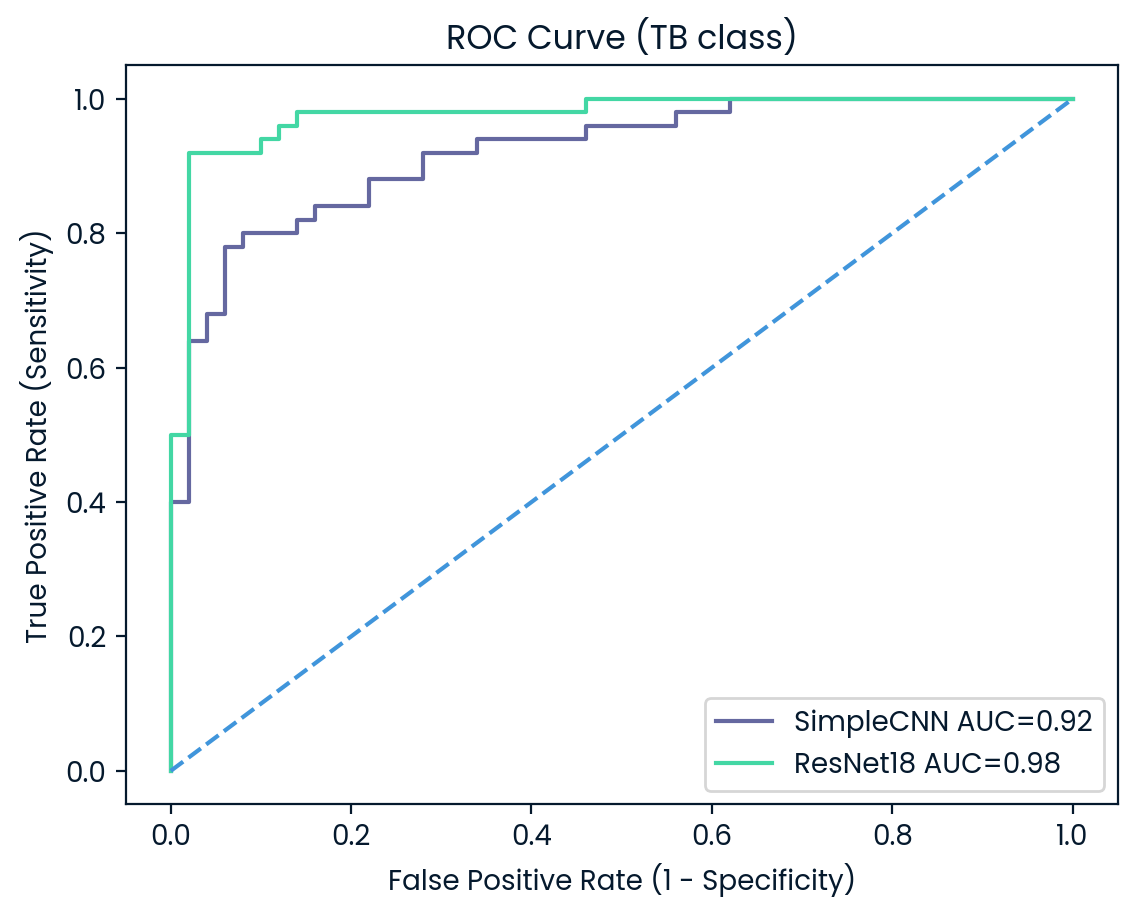

In [19]:
# Use y_prob (SimpleCNN) and y_prob_tl (ResNet) from the evaluation steps above.

fpr_s, tpr_s, _ = roc_curve(y_true,    y_prob[:, 1])      # TB is index 1
auc_s = auc(fpr_s, tpr_s)

fpr_t, tpr_t, _ = roc_curve(y_true_tl, y_prob_tl[:, 1])
auc_t = auc(fpr_t, tpr_t)

plt.figure()
plt.plot(fpr_s, tpr_s, label=f"SimpleCNN AUC={auc_s:.2f}")
plt.plot(fpr_t, tpr_t, label=f"ResNet18 AUC={auc_t:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve (TB class)")
plt.legend()
plt.show()

In [20]:
results = {
    "SimpleCNN": {
        "Accuracy": float((y_pred == y_true).mean()),
        **metrics_simple
    },
    "ResNet18_frozen": {
        "Accuracy": float((y_pred_tl == y_true_tl).mean()),
        **metrics_tl
    }
}
results

{'SimpleCNN': {'Accuracy': 0.8,
  'TP': 32,
  'TN': 48,
  'FP': 2,
  'FN': 18,
  'Sensitivity': 0.64,
  'Specificity': 0.96,
  'PPV': 0.9411764705882353,
  'NPV': 0.7272727272727273},
 'ResNet18_frozen': {'Accuracy': 0.76,
  'TP': 27,
  'TN': 49,
  'FP': 1,
  'FN': 23,
  'Sensitivity': 0.54,
  'Specificity': 0.98,
  'PPV': 0.9642857142857143,
  'NPV': 0.6805555555555556}}

# Findings & Results

## SimpleCNN
- **Accuracy:** 80%  
- **Sensitivity (Recall for TB):** 64%  
- **Specificity:** 96%  
- **PPV (TB Precision):** 94%  
- **NPV (Healthy Precision):** 73%  
Correctly identified most healthy cases but missed ~36% of TB cases.

---

## ResNet18 (Frozen Backbone)
- **Accuracy:** 76%  
- **Sensitivity (Recall for TB):** 54%  
- **Specificity:** 98%  
- **PPV (TB Precision):** 96%  
- **NPV (Healthy Precision):** 68%  
Very precise when predicting TB but missed nearly half of the TB cases.

---

## ROC Curve (TB class)
- **SimpleCNN AUC = 0.92**  
- **ResNet18 AUC = 0.98**  
---

## Key Takeaways
- Both models achieved high AUC, showing strong separation between TB and Healthy.  
- **SimpleCNN** had better recall for TB but weaker overall precision.  
- **ResNet18** achieved higher AUC and precision, but recall was lower when only the head was trained.  
- In medical settings, **Sensitivity matters most** — missing TB is riskier than false alarms.  
- With fine-tuning, ResNet18 could improve sensitivity further.

---

# **Nayab Irfan — AI Engineer**

---
